# Framework to analyse different stocks
***

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

***
## Data Sources

#### Load data from different stocks into a single dataframe

In [147]:
def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files"""
    df = pd.DataFrame(index=dates) #Create an empty dataframe
    if 'SPY' not in symbols: #add SPY for reference, if absent
        symbols.insert(0,'SPY')
        
    for symbol in symbols:
        df_temp= pd.read_csv("~/Dropbox/Dev/Systrading/Data/{}.csv".format(symbol), 
                             index_col="date", #indexe on Dates
                             parse_dates = True, #get time index objects
                             dayfirst = True, #AA/MM/DD or DD/MM/AA (International and European format)
                             usecols=['date','adjClose'], #only use the columns needed
                             na_values=['nan']) #missing values (week-ends for instance) into 'nan' string)
        #Rename 'Adj Close' column to the symbol name to prevent clash when adding more stocks
        df_temp = df_temp.rename(columns={'adjClose': symbol})
        df_temp.head()
        #Join the two dataframes using DataFrame.join() - only rules from df are kept, here it means only the datarange "dates" is kept (if missing values in df_temp: Nans)
        df = df.join(df_temp)
        if symbol == 'SPY': #drop dates where SPY did not trade
            df = df.dropna(subset=["SPY"])
            
    return df

***
## Inputs & Description

#### Choose the inputs you want to analyse: date range and symbols 

In [148]:
dates = pd.date_range('2016-01-01', '2017-12-31') #years 2016-2017 - dates in European format ie dayfirst
symbols = ['AAPL','GOOG'] #SPY will be added in get_data()
df = get_data(symbols, dates) #Get stock data to dataframe

#### Summary Description and Statistics

In [149]:
df.head(3)

,SPY,AAPL,GOOG
2016-01-04,192.273377,100.621750,741.84
2016-01-05,192.599350,98.100237,742.58
2016-01-06,190.169859,96.180449,743.62


In [150]:
df.tail(3)

,SPY,AAPL,GOOG
2017-12-27,266.254999,169.260423,1049.37
2017-12-28,266.802808,169.736654,1048.14
2017-12-29,265.796832,167.901180,1046.40


In [151]:
df.describe()

,SPY,AAPL,GOOG
count,503.000000,503.000000,503.000000
mean,221.525001,124.689494,832.455746
std,22.585777,26.481186,107.365710
min,174.904237,87.280220,668.260000
25%,203.032813,101.734754,742.845000
50%,220.962612,114.277210,797.850000
75%,239.591739,150.172449,929.465000
max,267.131494,175.034723,1077.140000


In [152]:
df.median()    #this computes for each column ie for each symbol

SPY     220.962612
AAPL    114.277210
GOOG    797.850000
dtype: float64

In [153]:
df.std()

SPY      22.585777
AAPL     26.481186
GOOG    107.365710
dtype: float64

***
## Missing values

In [154]:
#Fill forward with last value where missing values
df.fillna(method="ffill", inplace=True) #inplace argument will save all the changes in the same dataframe
df.fillna(method='bfill', inplace=True)   #then fill backwards for missing values at the very beginning
df.head(3)

,SPY,AAPL,GOOG
2016-01-04,192.273377,100.621750,741.84
2016-01-05,192.599350,98.100237,742.58
2016-01-06,190.169859,96.180449,743.62


***
## Normalising 

In [155]:
def normalize_data(df):
    """Normalize stock prices using the first row of the dataframe (the first stock price)"""
    return df / df.iloc[0]

In [156]:
df = normalize_data(df)
df.head(4)

,SPY,AAPL,GOOG
2016-01-04,1.000000,1.000000,1.000000
2016-01-05,1.001695,0.974941,1.000998
2016-01-06,0.989060,0.955861,1.002399
2016-01-07,0.965331,0.915520,0.979173


## Plotting 

In [157]:
def plot_data(df, title ="Stock prices"):
    """Plot stock prices"""
    ax = df.plot(title=title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()

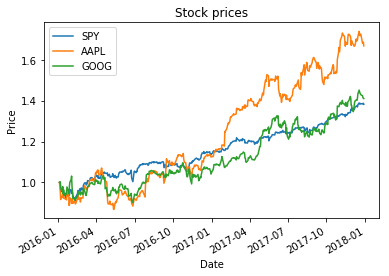

In [158]:
plot_data(df)

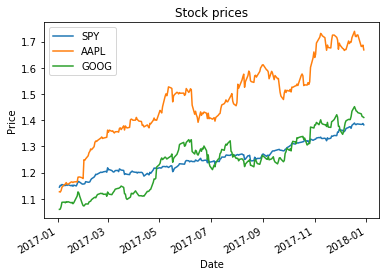

,SPY,AAPL,GOOG
2017-01-03,1.144586,1.127050,1.059716
2017-01-04,1.151396,1.125788,1.060741
2017-01-05,1.150481,1.131513,1.070339


In [159]:
df_2017 = df['2017']
plot_data(df_2017)
df_2017.head(3)

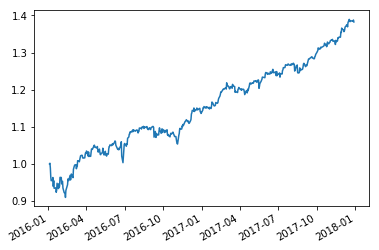

In [160]:
df['SPY'].plot()
plt.show()

***
## Rolling Mean and Bollinger bands 

In [161]:
def get_bollinger_bands(rm, rstd):
    """Return upper and lower Bollinger Bands."""
    upper_band = rm + 2 * rstd
    lower_band = rm - 2 * rstd
    return upper_band, lower_band 

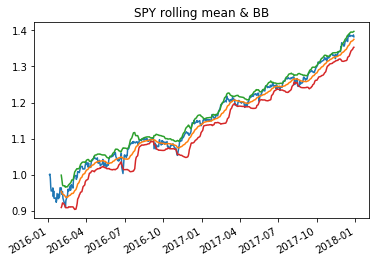

In [162]:
#Compute rolling mean and rolling standard deviation using a 20-day window
rm_SPY = df['SPY'].rolling(window=20).mean()
rstd_SPY = df['SPY'].rolling(window=20).std()
#Compute upper and lower bands
upper_band, lower_band = get_bollinger_bands(rm_SPY, rstd_SPY)
    
#Plot SPY data, retain matplotlib axis object
ax = df['SPY'].plot(title="SPY rolling mean & BB", label='SPY')
#Add rolling mean and Bollinger Bands to same plot
rm_SPY.plot(label="Rolling mean", ax=ax)
upper_band.plot(label='upper band', ax=ax)
lower_band.plot(label='lower band', ax=ax)

***
## Percentage Daily returns

#### Compute percentage daily returns

In [163]:
daily_returns = df.pct_change() #this is df / df.shift(1) - 1 
daily_returns.head(3)            #pandas leaves the 0th row full of NaNs

,SPY,AAPL,GOOG
2016-01-04,NaN,NaN,NaN
2016-01-05,0.001695,-0.025059,0.000998
2016-01-06,-0.012614,-0.019570,0.001401


In [164]:
daily_returns = daily_returns[1:] #as 1st value is always 0 and we don't want it for computing the statistics
daily_returns.head(3)

,SPY,AAPL,GOOG
2016-01-05,0.001695,-0.025059,0.000998
2016-01-06,-0.012614,-0.019570,0.001401
2016-01-07,-0.023992,-0.042205,-0.023170


In [165]:
#Daily returns in one line
pct_ret = df.pct_change()[1:]
pct_ret.head(3)

,SPY,AAPL,GOOG
2016-01-05,0.001695,-0.025059,0.000998
2016-01-06,-0.012614,-0.019570,0.001401
2016-01-07,-0.023992,-0.042205,-0.023170


#### Compute absolute daily returns 

In [166]:
abs_ret = df.diff()              #this is df - df.shift(1)
abs_ret.head(3)

,SPY,AAPL,GOOG
2016-01-04,NaN,NaN,NaN
2016-01-05,0.001695,-0.025059,0.000998
2016-01-06,-0.012636,-0.019079,0.001402


#### Plot daily returns using separate histograms for each symbol

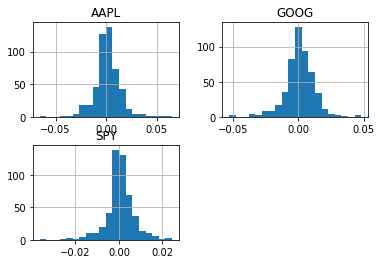

In [167]:
#Plot a histogram of daily returns (if several symbols, will plot several charts)
daily_returns.hist(bins=20) #changing nb of bins from default 10 to 20
plt.show()

#### Plot daily returns using a single histograms for all symbols

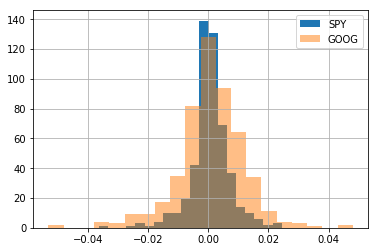

In [168]:
#Plot both histograms on the same chart
daily_returns['SPY'].hist(bins=20, label="SPY")
daily_returns['GOOG'].hist(bins=20, alpha=0.5, label="GOOG")  #alpha is for the transparence otherwise the first histogram is invisible
plt.legend(loc='upper right')
plt.show()

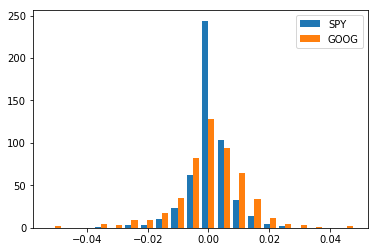

In [169]:
plt.hist([daily_returns['SPY'], daily_returns['GOOG']], bins=20, label=['SPY', 'GOOG'])
plt.legend(loc='best')
plt.show()

#### Add mean and +-1 std on graph 

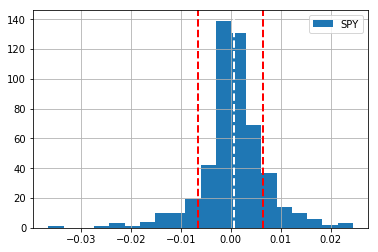

0.0006665256686668467

In [170]:
#Get mean and std of SPY then plot them
mean, std = daily_returns['SPY'].mean(), daily_returns['SPY'].std()

daily_returns['SPY'].hist(bins=20, label="SPY")
plt.axvline(mean,color='w',linestyle='dashed',linewidth=2) #color white & other arguments to differentiate from graph
plt.axvline(std,color='r',linestyle='dashed',linewidth=2)
plt.axvline(-std,color='r',linestyle='dashed',linewidth=2)
plt.legend(loc='upper right')
plt.show()

mean

#### Kurtosis 

In [171]:
#Compute kurtosis (measure of the "tailedness" of the probability distribution of a real-valued random variable)
daily_returns.kurtosis() #if >0 then fat tails, else <0 skinny tails

SPY     4.314041
AAPL    4.993030
GOOG    3.221330
dtype: float64

***
## Correlations

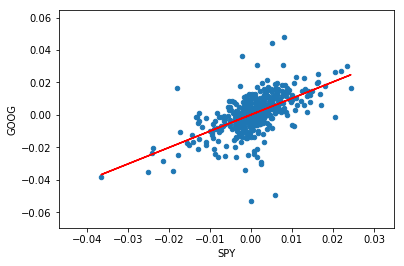

In [175]:
#Scatterplot SPY vs GOOG - specify x and y as df has other symbols
daily_returns.plot(kind='scatter',x='SPY',y='GOOG')

#Fit a line (polynomial of degree one) np.polyfit(x,y,degree of polynome), it returns the polynomial coefficient and intercept ie beta and alpha
beta_GOOG, alpha_GOOG = np.polyfit(daily_returns['SPY'],daily_returns['GOOG'],1)

#Plot the line
plt.plot(daily_returns['SPY'], beta_GOOG*daily_returns['SPY'] + alpha_GOOG, '-', color='r')
plt.show()

In [173]:
#Calculate correlation coefficient (using the default and most commom method='pearson')
daily_returns.corr()

,SPY,AAPL,GOOG
SPY,1.000000,0.546616,0.587712
AAPL,0.546616,1.000000,0.479770
GOOG,0.587712,0.479770,1.000000


In [174]:
df.corr()

,SPY,AAPL,GOOG
SPY,1.000000,0.957736,0.950535
AAPL,0.957736,1.000000,0.967246
GOOG,0.950535,0.967246,1.000000
